# Overview
I've been curious about how to acess and visualize pitch-level baseball data. I decided to seek out data from Felix Hernandez's perfect game from 2012 as a test case.  

I'm using the MLB Stats Python API from: https://github.com/toddrob99/MLB-StatsAPI

In [158]:
import statsapi
import pandas as pd
import seaborn as sns
import flatdict
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

## Get the mariner's team ID

In [80]:
team_id = statsapi.lookup_team('mariners')[0]['id']
team_id

136

## Get the game ID for the perfect game, 8/15/2012

In [82]:
game_id = statsapi.schedule(
    team=statsapi.lookup_team('mariners')[0]['id'],
    start_date='08/15/2012',
    end_date='08/15/2012'
)[0]['game_id']
game_id

319490

## View the box score to confirm that I have the correct game:

In [89]:
print(statsapi.boxscore(game_id))

------------------------------------------------------------------------------- | -------------------------------------------------------------------------------
Rays Batters                             AB   R   H  RBI BB   K  LOB AVG   OPS  | Mariners Batters                         AB   R   H  RBI BB   K  LOB AVG   OPS 
------------------------------------------------------------------------------- | -------------------------------------------------------------------------------
1 Fuld  LF                                3   0   0   0   0   0   0  .262 .605  | 1 Ackley  2B                              4   0   1   0   0   0   1  .225 .628 
2 Upton  CF                               3   0   0   0   0   1   0  .243 .700  | 2 Saunders, M  CF                         4   0   0   0   0   0   2  .237 .676 
3 Joyce  RF                               3   0   0   0   0   1   0  .269 .850  | 3 Montero, J  DH                          4   0   1   1   0   1   0  .266 .710 
4 Longoria  DH              

## Get the play by play and examine a bit

In [91]:
play_by_play=statsapi.get('game_playByPlay', params={'gamePk': game_id})

In [92]:
play_by_play.keys()

dict_keys(['copyright', 'allPlays', 'currentPlay', 'scoringPlays', 'playsByInning'])

In [70]:
play_by_play['allPlays'][0].keys()

dict_keys(['result', 'about', 'count', 'matchup', 'pitchIndex', 'actionIndex', 'runnerIndex', 'runners', 'playEvents', 'playEndTime', 'atBatIndex'])

## Unfold, flatten play by play into pitches
Each 'play' in the play by play is an at-bat, consisting of multiple pitches. I'm iterating over every at-bat, then every pitch, and making a list of flattened dictionaries, then converting to a dataframe

In [188]:
pitches = []
for at_bat_number in range(len(play_by_play['allPlays'])):
    # get some at-bat level data:
    matchup = dict(flatdict.FlatDict(play_by_play['allPlays'][at_bat_number]['matchup'], delimiter='_'))
    about = dict(flatdict.FlatDict(play_by_play['allPlays'][at_bat_number]['about'], delimiter='_'))
    
    for pitch in play_by_play['allPlays'][at_bat_number]['playEvents']:
        # get the pitch data, flattened
        pitch = dict(flatdict.FlatDict(pitch, delimiter='_'))
        
        # apply the at-bat level data
        pitch.update(matchup)
        pitch.update(about)
        
        # append to the list
        pitches.append(pitch)
        
# convert list of dicts to a dataframe
all_pitches = pd.DataFrame(pitches)

In [143]:
all_pitches

,details_call_code,details_call_description,details_description,details_code,details_ballColor,details_trailColor,details_isInPlay,details_isStrike,details_isBall,details_type_code,details_type_description,details_isOut,details_hasReview,count_balls,count_strikes,count_outs,pitchData_startSpeed,pitchData_endSpeed,pitchData_strikeZoneTop,pitchData_strikeZoneBottom,pitchData_coordinates_aY,pitchData_coordinates_aZ,pitchData_coordinates_pfxX,pitchData_coordinates_pfxZ,pitchData_coordinates_pX,pitchData_coordinates_pZ,pitchData_coordinates_vX0,pitchData_coordinates_vY0,pitchData_coordinates_vZ0,pitchData_coordinates_x,pitchData_coordinates_y,pitchData_coordinates_x0,pitchData_coordinates_y0,pitchData_coordinates_z0,pitchData_coordinates_aX,pitchData_breaks_breakAngle,pitchData_breaks_breakLength,pitchData_breaks_breakY,pitchData_breaks_spinRate,pitchData_breaks_spinDirection,pitchData_zone,pitchData_typeConfidence,index,pfxId,playId,pitchNumber,startTime,endTime,isPitch,type,batter_id,batter_fullName,batter_link,batSide_code,batSide_description,pitcher_id,pitcher_fullName,pitcher_link,pitchHand_code,pitchHand_description,batterHotColdZones,pitcherHotColdZones,splits_batter,splits_pitcher,splits_menOnBase,atBatIndex,halfInning,isTopInning,inning,isComplete,isScoringPlay,hasReview,hasOut,captivatingIndex,hitData_trajectory,hitData_hardness,hitData_location,hitData_coordinates_coordX,hitData_coordinates_coordY,postOnFirst_id,postOnFirst_fullName,postOnFirst_link,details_fromCatcher,postOnSecond_id,postOnSecond_fullName,postOnSecond_link,details_runnerGoing,details_event,details_eventType,details_awayScore,details_homeScore,details_isScoringPlay,actionPlayId,isBaseRunningPlay,player_id,player_link,umpire_id,umpire_link,isSubstitution,position_code,position_name,position_type,position_abbreviation,battingOrder,replacedPlayer_id,replacedPlayer_link
0,C,Called Strike,Called Strike,C,"rgba(170, 21, 11, 1.0)","rgba(152, 0, 101, 1.0)",False,True,False,FC,Cutter,False,False,0,1,0,92.2,86.0,3.19,1.38,25.96,-25.12,0.72,3.72,-0.82,3.17,4.29,-135.14,-2.77,126.18,130.38,-2.51,50.0,5.95,1.36,4.8,6.0,24.0,770.0,169.0,11.0,2.00,0,120815_124045,03194906-0016-0013-000c-f08cd117d70a,1.0,2012-08-15T19:40:29.000Z,2012-08-15T19:41:47.000Z,True,pitch,453539,Sam Fuld,/api/v1/people/453539,L,Left,433587,Felix Hernandez,/api/v1/people/433587,R,Right,[],[],vs_RHP,vs_LHB,Empty,0,top,True,1,True,False,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B,Ball,Ball,B,"rgba(39, 161, 39, 1.0)","rgba(188, 0, 33, 1.0)",False,False,True,FF,Four-Seam Fastball,False,False,1,1,0,91.5,84.8,3.08,1.26,27.04,-19.85,-1.86,6.68,-0.60,3.83,5.73,-134.07,-2.14,120.17,113.98,-2.51,50.0,6.04,-3.41,6.0,4.8,24.0,1383.0,195.0,11.0,2.00,1,120815_124058,03194906-0016-0023-000c-f08cd117d70a,2.0,2012-08-15T19:40:29.000Z,2012-08-15T19:41:47.000Z,True,pitch,453539,Sam Fuld,/api/v1/people/453539,L,Left,433587,Felix Hernandez,/api/v1/people/433587,R,Right,[],[],vs_RHP,vs_LHB,Empty,0,top,True,1,True,False,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B,Ball,Ball,B,"rgba(39, 161, 39, 1.0)","rgba(0, 34, 255, 1.0)",False,False,True,CU,Curveball,False,False,2,1,0,80.1,73.7,3.11,1.22,24.88,-45.99,4.48,-10.07,-0.87,3.40,2.80,-117.42,3.19,132.19,126.06,-2.66,50.0,6.34,6.17,8.4,13.2,24.0,1869.0,24.0,11.0,2.00,2,120815_124111,03194906-0016-0033-000c-f08cd117d70a,3.0,2012-08-15T19:40:29.000Z,2012-08-15T19:41:47.000Z,True,pitch,453539,Sam Fuld,/api/v1/people/453539,L,Left,433587,Felix Hernandez,/api/v1/people/433587,R,Right,[],[],vs_RHP,vs_LHB,Empty,0,top,True,1,True,False,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X,"In play, out(s)","In play, out(s)",X,"rgba(26, 86, 190, 1.0)","rgba(50, 0, 221, 1.0)",True,False,False,SI

## plot the start speed of every pitch

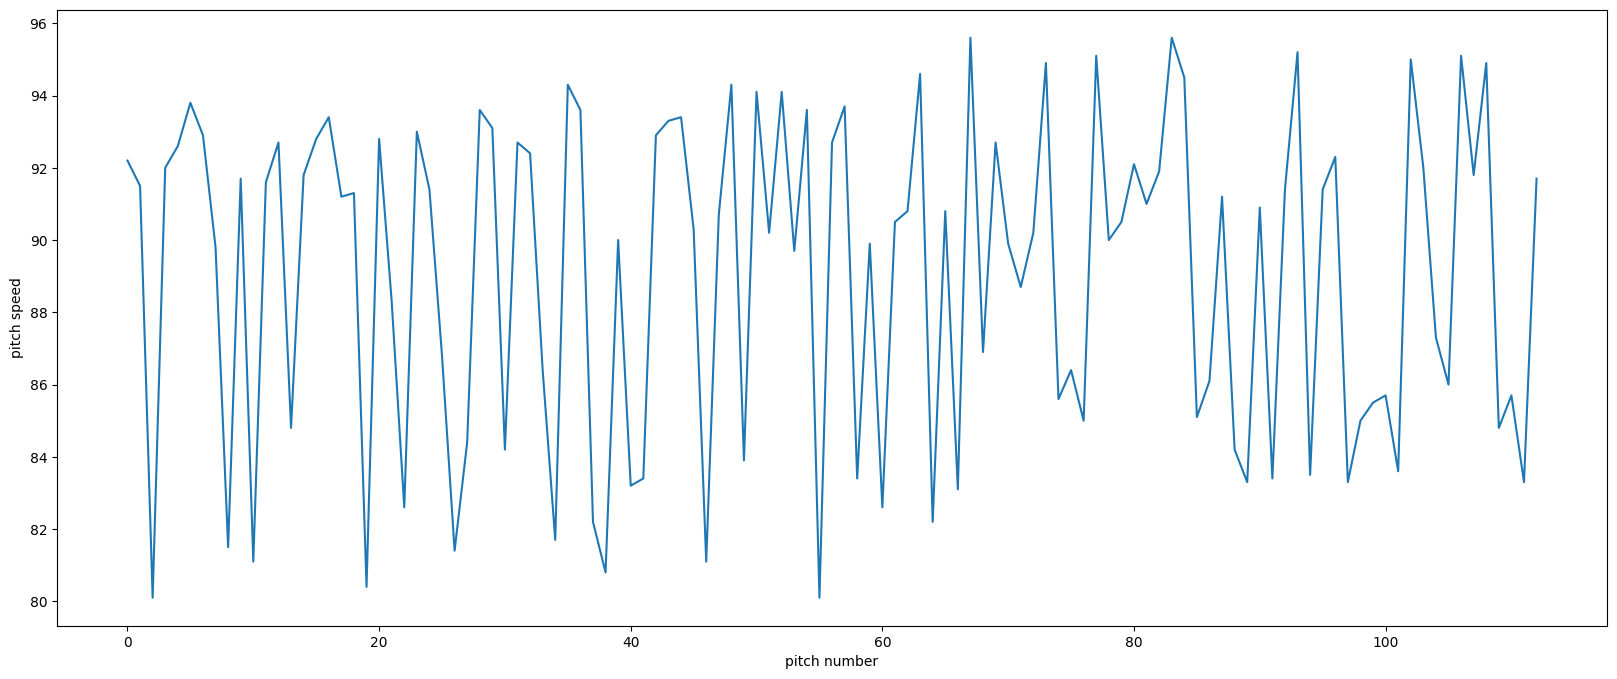

In [191]:
fig, ax = plt.subplots(figsize=(20, 8))
data=all_pitches.query('pitcher_fullName == "Felix Hernandez" and isPitch').reset_index(drop=True)
sns.lineplot(
    data=data,
    x=data.index,
    y='pitchData_startSpeed',
    ax=ax
)
ax.set_xlabel('pitch number');
ax.set_ylabel('pitch speed');

## plot the location of each pitch
* color=speed
* marker=pitch designation (ball, strike, etc)

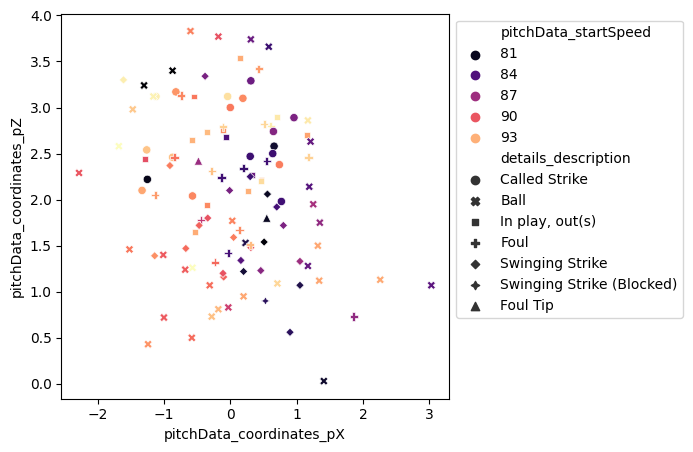

In [186]:
fig, ax = plt.subplots(figsize=(5,5))
# ax.axis('square')
sns.scatterplot(
    data=data,
    x='pitchData_coordinates_pX',
    y='pitchData_coordinates_pZ',
    hue='pitchData_startSpeed',
    palette='magma',
    style='details_description',
    ax=ax,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))